Loading model...
Loading scalers...
Total sequences: (43781, 48, 11) (43781,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

================ PREDICTION ================
BITCOIN 1h ahead forecast at 2025-11-18 11:00:00:
Predicted Close Price: 71098.43

============= ACTUAL VALUE ================
Actual Close Price:    91517.82



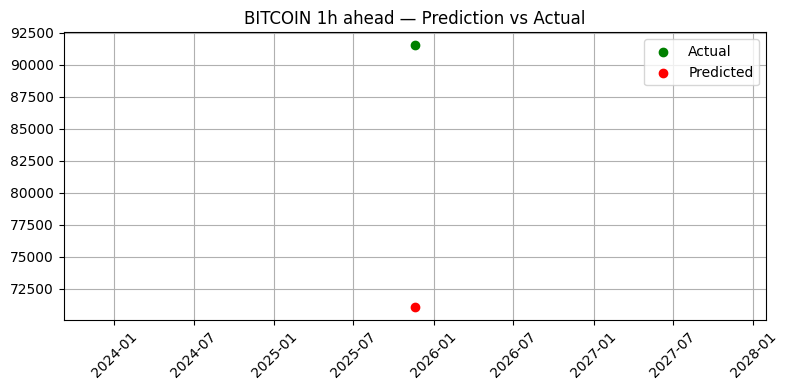

In [4]:
# predict_cardano.py

import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler  # just for type

# -----------------------------
# USER SETTINGS
# -----------------------------
COIN    = "bitcoin"
HORIZON = 1          # 1 or 24
SEQ_LEN = 48

BASE_DIR     = "/Users/ayushgupta/Desktop/ML-Driven-Web-Platform-for-Cryptocurrency-Price-Forecasting_November_Batch-5_2025"
MODEL_PATH   = f"{BASE_DIR}/Milestone_2/models/{COIN}/{HORIZON}h/final_lstm_{COIN}_{HORIZON}h.keras"
SCALER_DIR   = f"{BASE_DIR}/Milestone_1/data/scaled/{COIN}"
PROCESSED_CSV = f"{BASE_DIR}/Milestone_1/data/processed/{COIN}_processed.csv"

feature_cols = [
    "open","high","low","volume",
    "return_1h","volatility_24h",
    "ma_24","ma_168","ma_ratio",
    "vol_change","missing_flag"
]

# -----------------------------
# 1. LOAD MODEL + SCALERS
# -----------------------------
print("Loading model...")
model = tf.keras.models.load_model(MODEL_PATH)

print("Loading scalers...")
feature_scaler: MinMaxScaler = joblib.load(f"{SCALER_DIR}/{COIN}_feature_scaler.pkl")
price_scaler:   MinMaxScaler = joblib.load(f"{SCALER_DIR}/{COIN}_price_scaler.pkl")

# -----------------------------
# 2. LOAD PROCESSED DF (UNSCALED)
# -----------------------------
df = pd.read_csv(PROCESSED_CSV, parse_dates=["open_time"])
df = df.set_index("open_time").sort_index()

# -----------------------------
# 3. APPLY SAME SCALING AS TRAINING
# -----------------------------
df_scaled = df.copy()

df_scaled[feature_cols] = feature_scaler.transform(df_scaled[feature_cols])
df_scaled["close_scaled"] = price_scaler.transform(df_scaled[["close"]])

# -----------------------------
# 4. REBUILD SEQUENCES FOR THIS HORIZON
# -----------------------------
def create_sequence(df_local, horizon):
    X, y = [], []
    data_X = df_local[feature_cols].values
    data_y = df_local["close_scaled"].values

    for i in range(SEQ_LEN, len(df_local) - horizon):
        X.append(data_X[i-SEQ_LEN:i])
        y.append(data_y[i + horizon])

    return np.array(X), np.array(y)

X_all, y_all = create_sequence(df_scaled, HORIZON)
print("Total sequences:", X_all.shape, y_all.shape)

# We'll just use the LAST available sequence for prediction
X_last = X_all[-1].reshape(1, SEQ_LEN, len(feature_cols))
y_last_scaled = y_all[-1]  # true target in scaled space

# -----------------------------
# 5. PREDICT (SCALED → REAL)
# -----------------------------
scaled_pred = model.predict(X_last)[0][0]

# inverse scale both prediction and actual
pred_real = price_scaler.inverse_transform([[scaled_pred]])[0][0]
y_last_real = price_scaler.inverse_transform([[y_last_scaled]])[0][0]

# what timestamp does this y_last correspond to?
# target index in df is: SEQ_LEN + last_index_in_y + HORIZON
target_idx = SEQ_LEN + (len(y_all) - 1) + HORIZON
target_time = df.index[target_idx]

print("\n================ PREDICTION ================")
print(f"{COIN.upper()} {HORIZON}h ahead forecast at {target_time}:")
print(f"Predicted Close Price: {pred_real:.2f}")
print("============================================")

print("\n============= ACTUAL VALUE ================")
print(f"Actual Close Price:    {y_last_real:.2f}")
print("===========================================\n")

# -----------------------------
# 6. OPTIONAL: SMALL PLOT
# -----------------------------
plt.figure(figsize=(8,4))
plt.scatter([target_time], [y_last_real], label="Actual", color="green")
plt.scatter([target_time], [pred_real],   label="Predicted", color="red")
plt.legend()
plt.grid(True)
plt.title(f"{COIN.upper()} {HORIZON}h ahead — Prediction vs Actual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()